# Set up env

In [3]:
import carla
import numpy as np
from src.simulator import Simulator
from src.agent import NCPAgent
from src.model import Model

import torchvision
from IPython.display import display
import sys
import os
import torch

sys.path.append("CARLA_SIM/PythonAPI/carla/")
from agents.navigation.basic_agent import BasicAgent


# Data collection

In [ ]:
import carla
from random import random

random_rotation = 3 * random() - 1.5
mapping = {
    'Town01_opt': {
        'loc': carla.Location(x=176.589493, y=133.239151, z=0.300000), # 15 spawn point
        'rotation': carla.Rotation(0, 0 + random_rotation, 0)
    },
    'Town02_opt': {
        'loc': carla.Location(x=193.779999, y=142.190002, z=0.500000), # 15 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
    'Town03_opt': {
        # 'loc': carla.Location(x=-88.710991, y=-119.565231, z=0.275307), # 1 spawn point
        # 'rotation': carla.Rotation(0, 90 + random_rotation, 0)
        'loc': carla.Location(x=-0.710991, y=-120.565231, z=0.275307), # 1 spawn point
        'rotation': carla.Rotation(0, 90 + random_rotation, 0)
    },
    'Town04_opt': {
        'loc': carla.Location(405.320374, -48.450779, 0.281942), #222 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
}
print(random_rotation)

In [ ]:
simulator = Simulator(world_name='Town03_opt', dump_data=True, debug=True)

In [ ]:
import time

simulator.world.get_spectator()#.set_transform()
    # carla.Transform(
    #     location=carla.Location(x=398.7934265136719,
    #                             y=-56.03200912475586,
    #                             z=3.37939715385437)))

simulator.spawn_car_with_camera(
    rel_coordinates=carla.Location(x=1.2, z=1.9), # camera coords
    vehicle_coordinates=mapping[simulator.world_name]['loc'],
    vehicle_rotation=mapping[simulator.world_name]['rotation'],
    image_param=(640,640)
)
vehicle = simulator.get_vehicle()



output_size = 4
units = 19
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

base_model = Model(output_size, units)
# ncp.to(device)
if not os.path.isdir(f'out/{simulator.world_name}'):
    os.mkdir(f'out/{simulator.world_name}')
with open(f'out/{simulator.world_name}/data.txt', 'a+') as f:
    f.write(f'timestamp start = {time.time()}\n')
agent = NCPAgent(simulator, base_model, target_speed=10)

next_waypoint  = [simulator.world.get_map().get_waypoint(vehicle.get_location(),
                                                    project_to_road=True,
                                                    lane_type=(carla.LaneType.Driving))]

waypoints = []
dist_between_waypoints = 15
waypoint_num = 50
# waypoint_num = 350
# waypoint_num = 100
# waypoint_num = 10
for _ in range(waypoint_num):
    waypoints.append(next_waypoint[-1])
    # simulator.world.get_spectator().set_transform(next_waypoint[-1].transform)
    next_waypoint = next_waypoint[-1].next(dist_between_waypoints)

dest_idx = 2
dest = waypoints[dest_idx].transform.location
agent.set_destination(dest)
agent.set_target_speed(10)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)

In [ ]:
# # os.rmdir('./out/')

idx = 1
tmp = 0
waypoint = waypoints[idx]
to_PIL = torchvision.transforms.ToPILImage()

# loss_func = torch.nn.functional.mse_loss
# optimizer = torch.optim.Adam(ncp.parameters(), lr=0.001)

# # basic_agent = BasicAgent(vehicle=vehicle)
# trainer = Trainer(ncp, loss_func, optimizer)

while True:
    tmp += 1
    # if vehicle.get_location().distance(dest) < 0.5:
    #     print(f"Destination reached")
    #     break
    if (vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints / 4) or \
        (vehicle.get_location().distance(waypoint.transform.location) >= dist_between_waypoints * 2 and \
         vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints * 3):
        print(f'Waypoint {idx} was reached')
        if idx + 1 >= len(waypoints):
            print("The target has been reached, stopping the simulation")
            break
        waypoint = waypoints[idx + 1]
        idx += 1

    # control, movement, raw_data, out_tensor = agent.run_step()
    control, _, raw_data= agent.run_step(dump_data=True)
    vehicle.apply_control(control)
    if agent.simulator.image_frame is not None:
        with open(f'out/{simulator.world_name}/data.txt', 'a+') as f:
            f.write(f'{agent.simulator.image_frame} : {control.steer}\n')

    
    if agent.done():
        if dest_idx < waypoint_num - 1:
            dest_idx += 10
            dest_idx = min(dest_idx, waypoint_num - 1)
            print(f'Intermediate destination reached. Moving to waypoint {dest_idx}')
            agent.is_done = False
            agent.set_destination(waypoints[dest_idx].transform.location)
            continue

        print("The target has been reached, stopping the simulation")
        break
vehicle.apply_control(carla.VehicleControl(throttle = 0.0, brake=1.0, steer = 0.0))

In [ ]:
simulator.destroy_all()

# training

# test

In [11]:
import carla
import numpy as np
from src.simulator import Simulator
from src.agent import NCPAgent
from src.model import Model, DrivingModelModule, CustomDataset

from random import uniform, random

import torchvision
from IPython.display import display
import sys
import time
import torch
sys.path.append("CARLA_SIM/PythonAPI/carla/")
from agents.navigation.basic_agent import BasicAgent


In [3]:
def closest_point_on_segment_2d(current_point, line_a, line_b):
    ap = np.array([current_point.x - line_a.x, current_point.y - line_a.y])
    ab = np.array([line_b.x - line_a.x, line_b.y - line_a.y])
    ab_norm_sq = np.dot(ab, ab)

    if ab_norm_sq == 0:
        return carla.Location(x=line_a.x, y=line_a.y, z=0.0)

    t = np.clip(np.dot(ap, ab) / ab_norm_sq, 0, 1)
    closest_x = line_a.x + ab[0] * t
    closest_y = line_a.y + ab[1] * t
    return carla.Location(x=closest_x, y=closest_y, z=0.0)

def collect_metrics(sequence_len, checkpoint_name, units, experiment_num):
    random_rotation = 3 * random() - 1.5
    mapping = {
            'Town01_opt': {
                'loc': carla.Location(x=176.589493, y=133.239151, z=0.300000), # 15 spawn point
                'rotation': carla.Rotation(0, 0 + random_rotation, 0)
            },
            'Town02_opt': {
                'loc': carla.Location(x=193.779999, y=142.190002 + 35, z=0.500000), # 15 spawn point
                'rotation': carla.Rotation(0, -90 + random_rotation, 0)
            },
            'Town03_opt': {
                'loc': carla.Location(x=-88.710991, y=-119.565231, z=0.275307), # 1 spawn point
                'rotation': carla.Rotation(0, 90 + random_rotation, 0)
            },
            'Town04_opt': {
                'loc': carla.Location(405.320374, -48.450779, 0.281942), #222 spawn point
                'rotation': carla.Rotation(0, -90 + random_rotation, 0)
            },
    }
    print(random_rotation)

    metrics = {
        'MAD' : [],
        'MSD' : [],
    }

    for map_name in ['Town01_opt', 'Town02_opt', 'Town03_opt', 'Town04_opt']:
        simulator = Simulator(world_name=map_name,
                        debug=False,
                        dump_data=False,
                        sequence_len=sequence_len)
        simulator.spawn_car_with_camera(
            rel_coordinates=carla.Location(x=1.2, z=1.9), # camera coords
            vehicle_coordinates=mapping[simulator.world_name]['loc'],
            vehicle_rotation=mapping[simulator.world_name]['rotation'],
            image_param=(640,640)
        )

        output_size = 4
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(device)
        base_model = Model(output_size, units)
        ncp = DrivingModelModule.load_from_checkpoint(checkpoint_name,
            model=base_model,
            loss_func=torch.nn.L1Loss(),
            optimizer_cls=torch.optim.Adam,
            optimizer_kwargs={'lr': 0.0001},
            stb_weights=[1.0, 0.0, 0.0]
        )
        ncp.eval()
        agent = NCPAgent(simulator, ncp, target_speed=10)
        vehicle = simulator.get_vehicle()
        next_waypoint  = [simulator.world.get_map().get_waypoint(vehicle.get_location(),
                                                            project_to_road=True,
                                                            lane_type=(carla.LaneType.Driving))]
        waypoints = []
        dist_between_waypoints = 15
        waypoint_num = 5
        for _ in range(waypoint_num):
            waypoints.append(next_waypoint[-1])
            next_waypoint = next_waypoint[-1].next(dist_between_waypoints)

        dest_idx = 2
        dest = waypoints[dest_idx].transform.location
        agent.set_destination(dest)
        agent.set_target_speed(10)
        agent.ignore_traffic_lights(active=True)
        agent.ignore_stop_signs(active=True)

        idx = 1
        tmp = 0
        waypoint = waypoints[idx]

        loc_and_waypoint_map = []
        model_control_arr = []
        agent_control_arr = []

        time.sleep(3)

        while True:
            tmp += 1
            if (vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints / 4) or \
                (vehicle.get_location().distance(waypoint.transform.location) >= dist_between_waypoints * 2 and \
                vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints * 3):
                print(f'Waypoint {idx} was reached')
                if idx + 1 >= len(waypoints):
                    print("The target has been reached, stopping the simulation")
                    break
                waypoint = waypoints[idx + 1]
                idx += 1

            control, model_control, raw_data= agent.run_step(dump_data=False)
            model_steer = 2 * (model_control[0][-1][0].item() + 70) / 140 - 1 # to [-1;1]
            print(control.steer, model_steer)
            model_control_arr.append(model_steer)
            agent_control_arr.append(control.steer)
            
            vehicle.apply_control(carla.VehicleControl(throttle=control.throttle,
                                                    brake=control.brake,
                                                    steer=model_steer))
            
            loc_and_waypoint_map.append((vehicle.get_location(), idx))
            
            if agent.done():
                if dest_idx < waypoint_num - 1:
                    dest_idx += 10
                    dest_idx = min(dest_idx, waypoint_num - 1)
                    print(f'Intermediate destination reached. Moving to waypoint {dest_idx}')
                    agent.is_done = False
                    agent.set_destination(waypoints[dest_idx].transform.location)
                    continue

                print("The target has been reached, stopping the simulation")
                break
        vehicle.apply_control(carla.VehicleControl(throttle = 0.0, brake=1.0, steer = 0.0))

        simulator.destroy_all()
        
        n_samples = len([i for i in loc_and_waypoint_map if i[1] != 1])

        sum_of_eucl_dist = 0
        sum_of_sqr_eucl_dist = 0

        with open(f"exp{experiment_num}_{map_name}.csv", 'a+') as f:
            f.write("Model_control;Agent_control\n")
            for i in range(len(agent_control_arr)):
                f.write(f"{model_control_arr[i]};{agent_control_arr[i]}\n")

        for loc, wp_idx in loc_and_waypoint_map:
            if wp_idx == 1:
                continue
            start = waypoints[wp_idx-1].transform.location
            end = waypoints[wp_idx].transform.location
            proj_on_center = closest_point_on_segment_2d(loc, start, end)
            sum_of_eucl_dist += loc.distance(proj_on_center)
            sum_of_sqr_eucl_dist += loc.distance(proj_on_center) ** 2

        metrics['MAD'].append(sum_of_eucl_dist / n_samples)
        metrics['MSD'].append(sum_of_sqr_eucl_dist / n_samples)
        # MAD, MSD
    return metrics


In [16]:
sequence_len = 1
units = 512
checkpoint_name = f"model/max_ep_10_units_{units}_seq_{sequence_len}_lr_0.0001/epoch_epoch=09_val_loss=2.90006.ckpt"

In [17]:
metrics = collect_metrics(sequence_len,checkpoint_name,units,5)

-1.2954267042811716
cuda
alloc!
Camera stream started
30 1
0.10000000149011612 3.259219062856644e-06
30 1
0.1297563910484314 3.0827816641654238e-06
30 1
0.1299223154783249 3.087365101794859e-06
30 1
0.13008825480937958 3.0879122536742187e-06
30 1
0.13025417923927307 3.0879904182601337e-06
30 1
0.13042010366916656 3.0879904182601337e-06
30 1
0.13058604300022125 3.0879904182601337e-06
30 1
0.13075196743011475 3.0879904182601337e-06
30 1
0.13091789186000824 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879904182601337e-06
30 1
0.13108383119106293 3.0879870922539965e-06
30 1
0.13108383119106293 3.0879870922539965e-06
30 1
0.13108383119106293 3.0879870922539965e-06
30 1
0.13108383119106293 3.0879870922539965e-06
30 1
0.13108383119106293 3.0879870922539965e-06
30 1
0.13108383119106293 3.08798376602

In [18]:
print(f"{metrics['MAD'][0]};{metrics['MSD'][0]};{metrics['MAD'][1]};{metrics['MSD'][1]};{metrics['MAD'][2]};{metrics['MSD'][2]};{metrics['MAD'][3]};{metrics['MSD'][3]}")

1.3071649628906645;2.1728772839353594;1.082541961772811;1.7451293985396195;1.2764818881861117;2.123902912580813;1.3422230817849123;2.3152466571738803


In [4]:
sequence_len = 5
simulator = Simulator(world_name='Town04_opt',
                      debug=False,
                      dump_data=False,
                      sequence_len=sequence_len)

In [7]:
# random_rotation = 3 * random() - 1.5
random_rotation = 0
mapping = {
    'Town01_opt': {
        'loc': carla.Location(x=176.589493, y=133.239151, z=0.300000), # 15 spawn point
        'rotation': carla.Rotation(0, 0 + random_rotation, 0)
    },
    'Town02_opt': {
        'loc': carla.Location(x=193.779999, y=142.190002 + 35, z=0.500000), # 15 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
    'Town03_opt': {
        'loc': carla.Location(x=-88.710991, y=-119.565231, z=0.275307), # 1 spawn point
        'rotation': carla.Rotation(0, 90 + random_rotation, 0)
    },
    'Town04_opt': {
        'loc': carla.Location(405.320374, -48.450779, 0.281942), #222 spawn point
        'rotation': carla.Rotation(0, -90 + random_rotation, 0)
    },
}
print(random_rotation)

0


In [8]:
simulator.spawn_car_with_camera(
    rel_coordinates=carla.Location(x=1.2, z=1.9), # camera coords
    vehicle_coordinates=mapping[simulator.world_name]['loc'],
    vehicle_rotation=mapping[simulator.world_name]['rotation'],
    image_param=(640,640)
)
# vehicle = simulator.get_vehicle()
# print(f'Transforms : {vehicle.get_transform()}')

output_size = 4
units = 32
# units = 64
# units = 128
# units = 256
# units = 512
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [9]:
checkpoint_name = f"model/max_ep_10_units_{units}_seq_{sequence_len}_lr_0.0001/epoch_epoch=09_val_loss=2.89252.ckpt"

In [12]:
base_model = Model(output_size, units)
ncp = DrivingModelModule.load_from_checkpoint(checkpoint_name,
    model=base_model,
    loss_func=torch.nn.L1Loss(),
    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={'lr': 0.0001},
    stb_weights=[1.0, 0.0, 0.0]
)
ncp.eval()
agent = NCPAgent(simulator, ncp, target_speed=10)

alloc!
Camera stream started


In [13]:
vehicle = simulator.get_vehicle()
next_waypoint  = [simulator.world.get_map().get_waypoint(vehicle.get_location(),
                                                    project_to_road=True,
                                                    lane_type=(carla.LaneType.Driving))]
waypoints = []
dist_between_waypoints = 15
waypoint_num = 5
# waypoint_num = 10
# waypoint_num = 350
# waypoint_num = 100
# waypoint_num = 10
for _ in range(waypoint_num):
    waypoints.append(next_waypoint[-1])
    # simulator.world.get_spectator().set_transform(next_waypoint[-1].transform)
    next_waypoint = next_waypoint[-1].next(dist_between_waypoints)

dest_idx = 2
dest = waypoints[dest_idx].transform.location
agent.set_destination(dest)
agent.set_target_speed(10)
agent.ignore_traffic_lights(active=True)
agent.ignore_stop_signs(active=True)

In [14]:
# # os.rmdir('./out/')

idx = 1
tmp = 0
waypoint = waypoints[idx]

loc_and_waypoint_map = []
model_control_arr = []
agent_control_arr = []

while True:
    tmp += 1
    if (vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints / 4) or \
        (vehicle.get_location().distance(waypoint.transform.location) >= dist_between_waypoints * 2 and \
         vehicle.get_location().distance(waypoint.transform.location) <= dist_between_waypoints * 3):
        print(f'Waypoint {idx} was reached')
        if idx + 1 >= len(waypoints):
            print("The target has been reached, stopping the simulation")
            break
        waypoint = waypoints[idx + 1]
        idx += 1

    # control, movement, raw_data, out_tensor = agent.run_step()
    control, model_control, raw_data= agent.run_step(dump_data=False)
    model_steer = 2 * (model_control[0][-1][0].item() + 70) / 140 - 1 # to [-1;1]
    print(control.steer, model_steer)
    model_control_arr.append(model_steer)
    agent_control_arr.append(control.steer)
    
    vehicle.apply_control(carla.VehicleControl(throttle=control.throttle,
                                               brake=control.brake,
                                               steer=model_steer))
    
    loc_and_waypoint_map.append((vehicle.get_location(), idx))
    
    if agent.done():
        if dest_idx < waypoint_num - 1:
            dest_idx += 10
            dest_idx = min(dest_idx, waypoint_num - 1)
            print(f'Intermediate destination reached. Moving to waypoint {dest_idx}')
            agent.is_done = False
            agent.set_destination(waypoints[dest_idx].transform.location)
            continue

        print("The target has been reached, stopping the simulation")
        break
vehicle.apply_control(carla.VehicleControl(throttle = 0.0, brake=1.0, steer = 0.0))

150 5
0.01516609638929367 -4.066982572603628e-06
150 5
0.01520498376339674 -4.066982572603628e-06
150 5
0.015224427916109562 -4.066982572603628e-06
150 5
0.01524387113749981 -4.066982572603628e-06
150 5
0.015263315290212631 -4.066982572603628e-06
150 5
0.015282759442925453 -4.066982572603628e-06
150 5
0.0153022026643157 -4.066982572603628e-06
150 5
0.015321646817028522 -4.066982572603628e-06
150 5
0.01534109003841877 -4.066982572603628e-06
150 5
0.015360534191131592 -4.066982572603628e-06
150 5
0.015360534191131592 -4.066982572603628e-06
150 5
0.015360534191131592 -4.066982572603628e-06
150 5
0.015360534191131592 -4.066982572603628e-06
150 5
0.015360534191131592 -4.066982572603628e-06
150 5
0.015403885394334793 -4.066982572603628e-06
150 5
0.015427330508828163 -4.066982572603628e-06
150 5
0.015919072553515434 -4.066982572603628e-06
150 5
0.016038866713643074 -4.066982572603628e-06
150 5
0.014178946614265442 -4.066982572603628e-06
150 5
0.01506960391998291 -4.066982572603628e-06
150 5
0

KeyboardInterrupt: 

In [ ]:
b = agent.sensors_data_storage.get_sensor_data('camera_front')
b[-10][0].shape

In [15]:
simulator.destroy_all()

Camera stream stopped


In [ ]:
from torchvision import transforms
from PIL import Image
import torch

to_pil = transforms.ToPILImage()
pil_image = to_pil(b[-1][0])
pil_image.save('test1.jpg')

pil_image = to_pil(b[0][0])
pil_image.save('test2.jpg')


In [ ]:
with open("exp1_t3.csv", 'a+') as f:
    f.write("Model_control;Agent_control\n")
    for i in range(len(agent_control_arr)):
        f.write(f"{model_control_arr[i]};{agent_control_arr[i]}\n")

In [ ]:
def closest_point_on_segment_2d(current_point, line_a, line_b):
    ap = np.array([current_point.x - line_a.x, current_point.y - line_a.y])
    ab = np.array([line_b.x - line_a.x, line_b.y - line_a.y])
    ab_norm_sq = np.dot(ab, ab)

    if ab_norm_sq == 0:
        return carla.Location(x=line_a.x, y=line_a.y, z=0.0)

    t = np.clip(np.dot(ap, ab) / ab_norm_sq, 0, 1)
    closest_x = line_a.x + ab[0] * t
    closest_y = line_a.y + ab[1] * t
    return carla.Location(x=closest_x, y=closest_y, z=0.0)

In [5]:
len(loc_and_waypoint_map)

NameError: name 'loc_and_waypoint_map' is not defined

In [ ]:
n_samples = len([i for i in loc_and_waypoint_map if i[1] != 1])

sum_of_eucl_dist = 0
sum_of_sqr_eucl_dist = 0

for loc, wp_idx in loc_and_waypoint_map:
    if wp_idx == 1:
        continue
    start = waypoints[wp_idx-1].transform.location
    end = waypoints[wp_idx].transform.location
    proj_on_center = closest_point_on_segment_2d(loc, start, end)
    # print(f"Loc_v = ({loc.x}, {loc.y}, {loc.z})\t Loc_pr = ({proj_on_center.x}, {proj_on_center.y}, {proj_on_center.z})")
    sum_of_eucl_dist += loc.distance(proj_on_center)
    sum_of_sqr_eucl_dist += loc.distance(proj_on_center) ** 2

MAD = sum_of_eucl_dist / n_samples
MSD = sum_of_sqr_eucl_dist / n_samples
MAD, MSD

- l1 loss instead of mse
- sum l1 + l2?
- Training framework (pt lightning, catalyst)
- Save gt + loss. If gt 0 and loss 0 - irrelevant | gt 0 loss >> 0 -> relevant data

1. upscale image
2. agent logging
3. check if interactive can be added
4. Метрики отражающие ситуацию (насколько хорошо агент справляется с задачей)
   - скорость смещения от края в центру
   - средний угол отклонения от гт
   - отношение пересечений разметки к пройденной дист

In [ ]:
from src.model import CustomDataset
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

datasets = [
    {'annotations_file': 'out/Town01_opt/data.txt', 'img_dir': 'out/Town01_opt/'},
    {'annotations_file': 'out/Town02_opt/data.txt', 'img_dir': 'out/Town02_opt/'},
    {'annotations_file': 'out/Town03_opt/data.txt', 'img_dir': 'out/Town03_opt/'},
    {'annotations_file': 'out/Town04_opt/data.txt', 'img_dir': 'out/Town04_opt/'},
]

dataset = CustomDataset(
    datasets=datasets,
    sequence_length=10
)

images = dataset[140][0].squeeze()
imgs = []
for img in images:
    # print(img.max(), img.min())
    _img = torchvision.transforms.functional.to_pil_image(img)
    imgs.append(_img)
dataset[140][1]

In [ ]:
import numpy as np
# arr = np.array(_img)
# arr.max(), arr.min()
x = torchvision.transforms.functional.pil_to_tensor(_img)

In [ ]:
x.max(), x.min()

In [ ]:
dataset[140][1]
# dataset[140][1]

In [ ]:
from src.model import CustomDataset

datasets = [
    {'annotations_file': 'out/Town01_opt/data.txt', 'img_dir': 'out/Town01_opt/'},
    {'annotations_file': 'out/Town02_opt/data.txt', 'img_dir': 'out/Town02_opt/'},
    {'annotations_file': 'out/Town03_opt/data.txt', 'img_dir': 'out/Town03_opt/'},
    {'annotations_file': 'out/Town04_opt/data.txt', 'img_dir': 'out/Town04_opt/'},
]

dataset = CustomDataset(
    datasets=datasets,
    sequence_length=10
)

steer_angles_train = dataset.data_groups[1]['steer_angles']
steer_angles_train.extend(dataset.data_groups[2]['steer_angles'])
steer_angles_train.extend(dataset.data_groups[3]['steer_angles'])

steer_angles_test = dataset.data_groups[0]['steer_angles']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Steering angle':steer_angles_train})
plt.figure(figsize=(15,12))
ax = df['Steering angle'].hist(bins=100)
ax.set_xlabel("Steering angle")
ax.set_ylabel("Number of samples")

plt.xticks([x for x in range(-60, 60, 2)])

ax

In [ ]:
df = pd.DataFrame({'Steering angle':steer_angles_test})
ax = df['Steering angle'].hist()
ax.set_xlabel("Steering angle")
ax.set_ylabel("Number of samples")

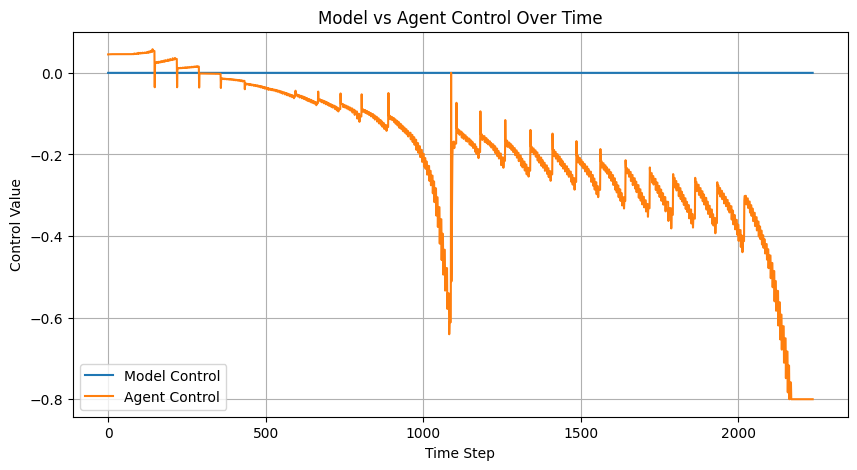

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file (adjust the path if needed)
df = pd.read_csv('exp1_Town01_opt.csv', delimiter=';')

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(df['Model_control'], label='Model Control')
plt.plot(df['Agent_control'], label='Agent Control')

# Add titles and labels
plt.title('Model vs Agent Control Over Time')
plt.xlabel('Time Step')
plt.ylabel('Control Value')

# Add legend
plt.legend()

# Optional: add grid
plt.grid(True)

# Show the plot
plt.show()
